<h1 style="text-align:center;">Unveiling Employee Retention Insights:<br> A Jupyter Notebook Approach to Predicting Turnover and Evaluating Employee Risk Levels</h1>

<p style="text-align:center; font-size:large;">Created By: Christopher Castor</p>

## Overview
This notebook aims to analyze and predict employee turnover at a fictitious company. The notebook leverages python, data visualizations, and machine learning techniques to provide insights into factors contributing to turnover and to create a predictive model to assess employee risk level.

## Data
The dataset used in this analysis was created by Christopher Castor and includes information on employee characteristics, performance, and turnover status. The features will be utilized to train and evaluate the predictive model.

## Table of Contents

- <a href='#1'>1. Import Libraries</a>
- <a href='#2'>2. Define Functions</a>
- <a href='#3'>3. Read Data</a>
- <a href='#4'>4. Exploratory Data Analysis</a>
- <a href='#5'>5. Building Machine Learning Models</a>
- <a href='#6'>6. Concluding Remarks</a>


# <a id='1'>1. Import Libraries</a>

In [1]:
# Importing standard libraries
import numpy as np
import pandas as pd
import os
from functools import reduce

# Importing visualization libraries
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')

# Importing model building libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
import shap

# Setting optional settings
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# <a id='2'>2. Define Functions</a>

In [2]:
def build_chart(df, var, target, rotation, sort_order_list=None):
    '''
    Build a chart that visualizes the relationship between a feature and employee turnover.

    Parameters:
    - df: DataFrame containing the dataset
    - var: Feature for which the chart will be built
    - target: Binary target variable indicating turnover
    - rotation: Rotation angle for x-axis labels in the chart
    - sort_order_list: Optional list to specify the desired order of x-axis

    Returns:
    - Display a chart with bars representing feature distribution
    '''
    
    # Calculate counts and average turnover rate and merge into one DataFrame
    var_count = df[var].value_counts(dropna=False).to_frame().reset_index()
    var_avg_turnover = df[target].groupby(df[var]).mean().to_frame().reset_index().rename(columns={target:'avg_{}'.format(target)})
    var_chart_data = pd.merge(var_count, var_avg_turnover, on=[var]).sort_values(by=var).reset_index(drop=True)
    
    # If sort order is given, convert var to categorical and apply sorting
    if sort_order_list is not None:
        var_chart_data[var] = pd.Categorical(var_chart_data[var], sort_order_list)
        var_chart_data = var_chart_data.sort_values(by=var).reset_index(drop=True)
        var_chart_data[var] = var_chart_data[var].astype(str)
    
    # Create chart
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Create bar chart representing the feature distribution (using left y-axis)
    ax1.bar(var_chart_data[var], var_chart_data['count'], color='lightsteelblue')
    ax1.set_ylabel('Count')
    ax1.tick_params('y')
    ax1.tick_params(axis='x', labelrotation=rotation)
    ax1.set_ylim(0, max(df[var].value_counts())*1.25)

    # Create line chart representing the average turnover rate (using right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(var_chart_data[var], var_chart_data['avg_{}'.format(target)], color='black', linewidth=3, label='Average Turnover')
    ax2.set_ylabel('Turnover Rate')
    ax2.tick_params('y')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='best')
    
    return plt.show()

In [3]:
def preprocess_dataset(df, label_encoding_threshold=2, minmax_feature_range=(0,5), columns_to_exclude=['turnover', 'employee_id']):
    '''
    Preprocess a dataset by performing label encoding on categorical columns with 2 or fewer unique values,
    one-hot encode the rest and scale numeric columns using MinMaxScaler.

    Parameters:
    - df: DataFrame containing the dataset
    - label_encoding_threshold: The threshold for unique values to determine label encoding (default is 2)
    - minmax_feature_range: Tuple specifying the feature range for MinMaxScaler (default is (0, 5))
    - columns_to_exclude: List of columns to exclude from label encoding and scaling (default is ['turnover', 'employee_id'])

    Returns:
    - DataFrame with encoded and scaled columns
    '''
    
    # Create label encoder
    le = LabelEncoder()

    # Encode columns with 2 or fewer unique values
    for col in df.columns[1:]:  # Exclude the first column if it's an index or ID
        if df[col].dtype == 'object' and len(df[col].unique()) <= label_encoding_threshold:
            df[col] = le.fit_transform(df[col])

    # One-hot encode remaining categorical columns
    df_encoded = pd.get_dummies(df.drop(columns_to_exclude, axis=1), drop_first=True)

    # Join columns_to_exclude to the encoded dataset
    df = pd.concat([df[columns_to_exclude], df_encoded], axis=1)
    
    # Create scaler using MinMaxScaler
    scaler = MinMaxScaler(feature_range=minmax_feature_range)

    # Get list of numeric columns and perform scaling
    numeric_columns = [col for col in df.columns if col not in columns_to_exclude and pd.api.types.is_numeric_dtype(df[col])]
    for col in numeric_columns:
        df[col] = scaler.fit_transform(df[[col]].astype(float))

    return df

In [4]:
def perform_randomized_search(algorithm, params, X_train, y_train, n_iter=10, scoring='roc_auc', cv=5, verbose=0):
    '''
    Perform RandomizedSearchCV for a given algorithm, hyperparameter grid, and training data.

    Parameters:
    - algorithm: Machine learning algorithm
    - params: Hyperparameter grid for the algorithm
    - X_train: Training feature matrix
    - y_train: Training labels
    - n_iter: Number of parameter settings that are sampled
    - scoring: Evaluation metric for cross-validated performance
    - cv: Number of folds in cross-validation
    - verbose: Controls the verbosity (higher values give more output)

    Returns:
    - Fitted model with the best parameters.
    '''
    
    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(algorithm, param_distributions=params, n_iter=n_iter, scoring=scoring, n_jobs=-1, cv=cv, verbose=verbose, error_score='raise')
            
    # Fit RandomizedSearchCV on training data
    random_search.fit(X_train, y_train)

    return random_search.best_estimator_

# <a id='3'>3. Read Data</a>

In [5]:
# Read in sourcefile and print overview
source_file = pd.read_csv('./data/Sample_Employee_Turnover.csv', dtype={'employee_id':'str'})
print ('Rows: {:,}, Columns: {:,}, Missing Values: {:,}'.format(source_file.shape[0], source_file.shape[1], source_file.isnull().sum().values.sum()))

# Make a copy of the original sourcefile
employee_turnover = source_file.copy()

# Display columns by data type
print('\n Columns By Data Type')
display(employee_turnover.dtypes.to_frame().T)

# Display first 5 rows
print('\n Sample Data')
display(employee_turnover.head())

Rows: 1,000, Columns: 14, Missing Values: 0

 Columns By Data Type


,employee_id,department,tenure,is_mentor,is_mentee,fully_remote,surveys_taken,training_taken,relative_salary_level,bonus,employment_status,awards,team_level_survey_satisfication,turnover
0,object,object,object,object,object,object,int64,object,object,object,object,int64,object,int64



 Sample Data


,employee_id,department,tenure,is_mentor,is_mentee,fully_remote,surveys_taken,training_taken,relative_salary_level,bonus,employment_status,awards,team_level_survey_satisfication,turnover
0,1,IT,High,Y,N,N,10,Y,High,Y,Full Time,18,Green,0
1,2,HR,High,Y,N,N,10,Y,High,Y,Full Time,12,Green,0
2,3,Legal,High,Y,N,N,10,Y,High,Y,Full Time,19,Green,0
3,4,HR,High,Y,N,N,10,Y,High,Y,Full Time,19,Green,0
4,5,Sales,High,Y,N,N,10,Y,High,Y,Full Time,9,Green,0


# <a id='4'>4. Exploratory Data Analysis</a>

## <a id='4.1'>4.1. Employee Turnover</a>

Out of the 1,000 employees in the dataset, **135** left the company giving an overall turnover rate of **13.5%**

In [6]:
count = employee_turnover['turnover'].value_counts(dropna=False)
pct_total = employee_turnover['turnover'].value_counts(normalize=True) * 100
pd.DataFrame({'Employees': count, 'Percent of Total': pct_total})

,Employees,Percent of Total
turnover,,
0,865,86.5
1,135,13.5


## <a id='4.2'>4.2. Average Turnover Rate By Feature</a>

### Department

There are **10** unique departments and there isn't a large difference between number of employees in each department. \
The turnover rate is relatively stable across all departments, with slight peaks in **HR** and **Sales**.

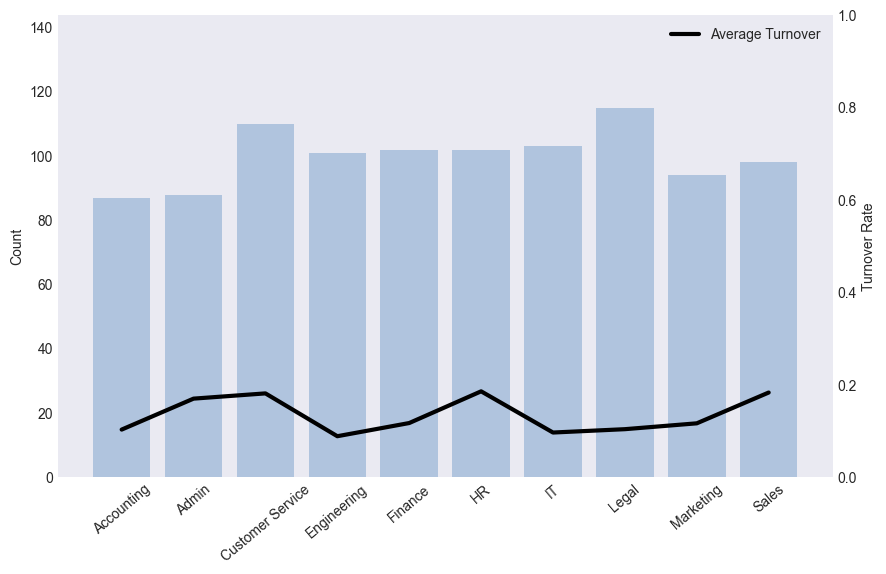

In [7]:
build_chart(df=employee_turnover, var='department', target='turnover', rotation=40)

### Tenure

The decreasing turnover rate as the tenure classification moves from “Low” to “High” may indicate that \
the company is doing a **good job of retaining long-term employees but struggling with newer employees**.

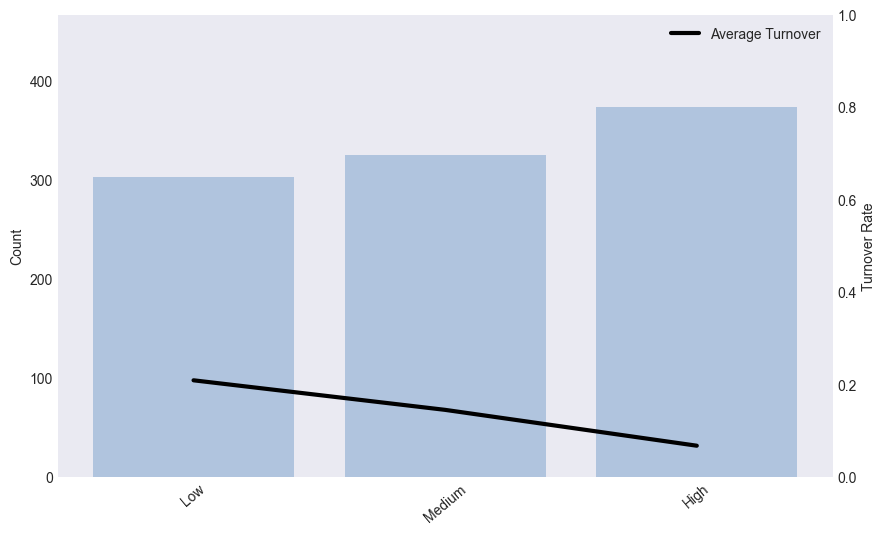

In [8]:
build_chart(df=employee_turnover, var='tenure', target='turnover', rotation=40, sort_order_list=['Low','Medium','High'])

### Employee Is A Mentor

Employees who are not mentors (N) have a higher count but also a higher turnover rate than those who are mentors (Y). \
This suggests that **being a mentor could potentially be correlated with lower turnover rates**.

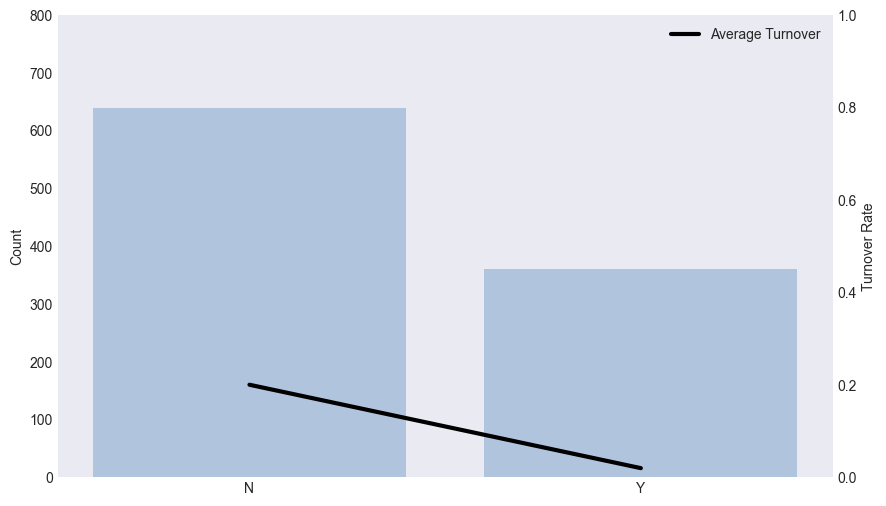

In [9]:
build_chart(df=employee_turnover, var='is_mentor', target='turnover', rotation=0)

### Employee Is A Mentee

Similar to whether an employee is a mentor, employees who are not mentees (N) have a higher count but also a higher turnover rate than those who are mentees (Y). \
This suggests that **being a mentee could potentially be correlated with lower turnover rates**.

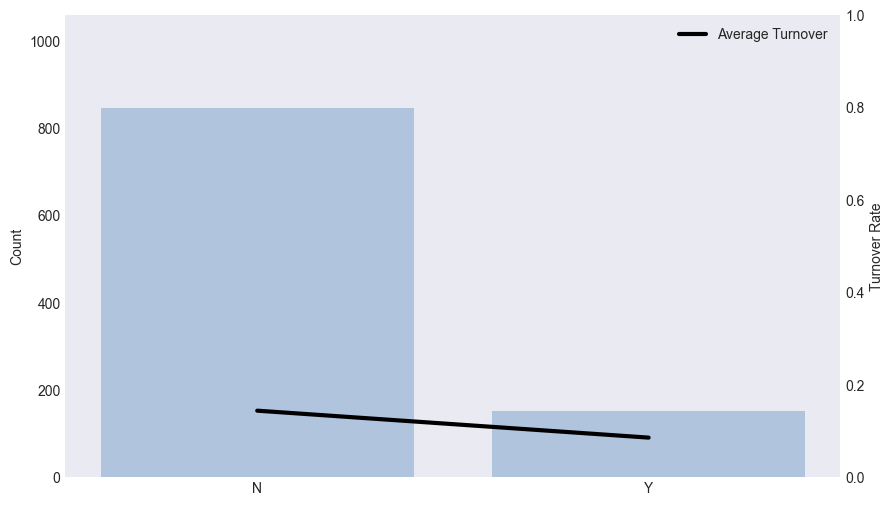

In [10]:
build_chart(df=employee_turnover, var='is_mentee', target='turnover', rotation=0)

### Fully Remote

There are significantly more employees in the office versus fully remote. \
The higher turnover rate for those who are fully remote (Y) may indicate that **remote work could potentially be correlated with higher turnover rates**.

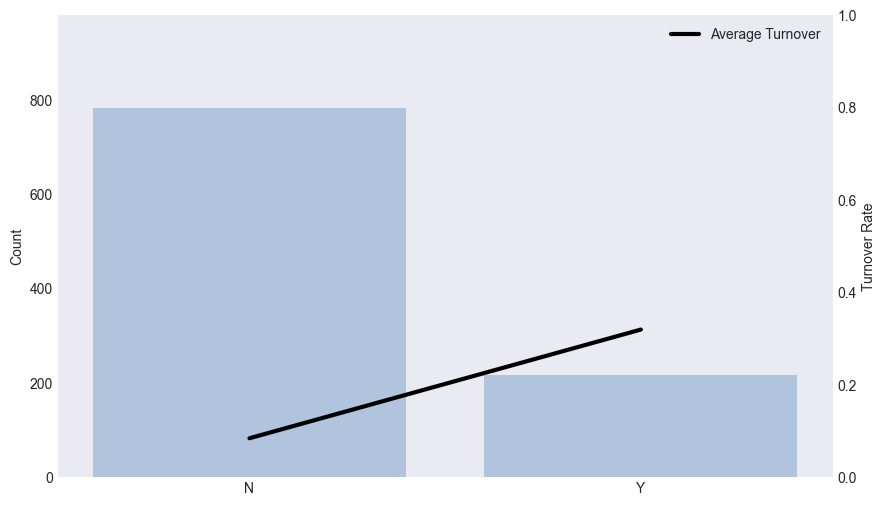

In [11]:
build_chart(df=employee_turnover, var='fully_remote', target='turnover', rotation=0)

### Number of Surveys Taken

Around **30%** of employees have taken all 10 surveys and there is a **general decline in turnover rate as number of surveys taken increases**. 

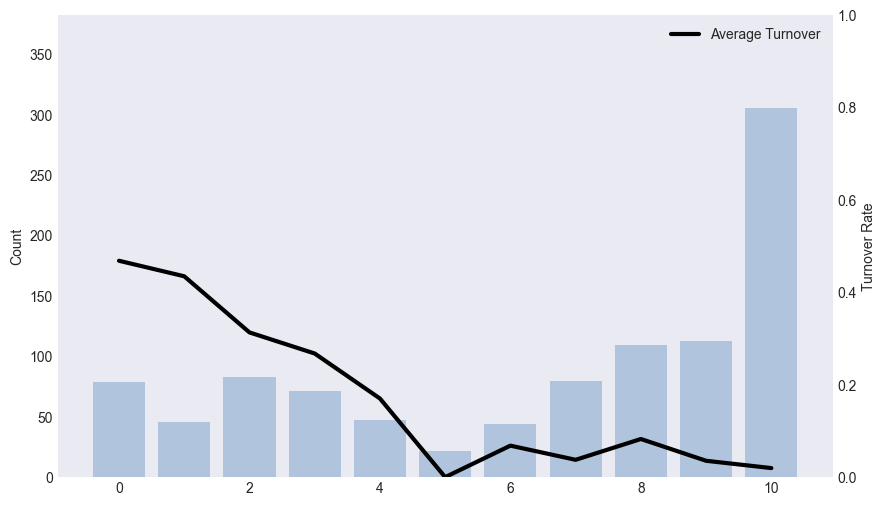

In [12]:
build_chart(df=employee_turnover, var='surveys_taken', target='turnover', rotation=0)

### Employee Completed Training

The majority of employees have completed training but the high turnover rate for those that didn't \
may indicate that **completing training could potentially be correlated with lower turnover rates**. 

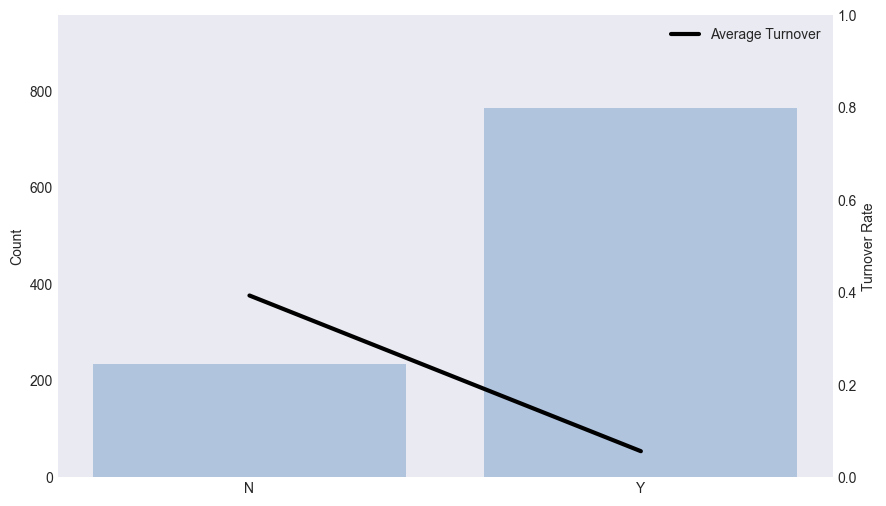

In [13]:
build_chart(df=employee_turnover, var='training_taken', target='turnover', rotation=0)

### Salary Relative To Peers

Employees with a low salary relative to their peers have a higher turnover rate, while those with medium and high salaries have lower turnover rates. \
This suggests that **employees who are paid less compared to their peers might be more likely to leave the company**.

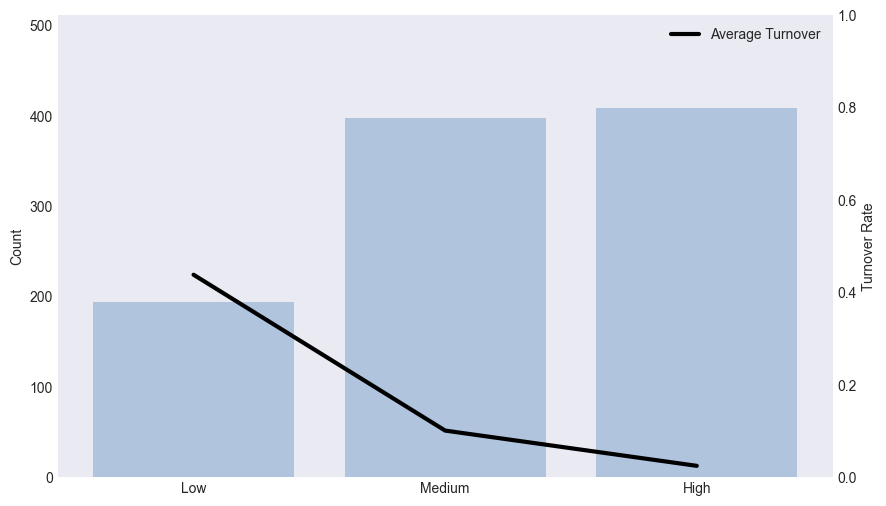

In [14]:
build_chart(df=employee_turnover, var='relative_salary_level', target='turnover', rotation=0, sort_order_list=['Low','Medium','High'])

### Employee Received Bonus

The majority of employees received a bonus but the high turnover rate for those that didn't \
may indicate that **receiving a bonus could potentially be correlated with lower turnover rates**. 

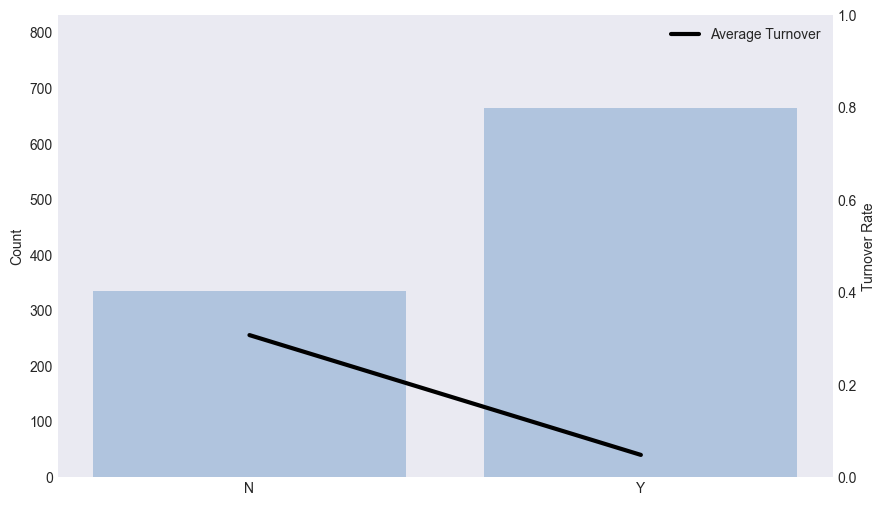

In [15]:
build_chart(df=employee_turnover, var='bonus', target='turnover', rotation=0)

### Employment Classification

The majority of employees are full time but the high turnover rate for those that aren't \
may indicate that **being full time instead of part time could potentially be correlated with lower turnover rates**. 

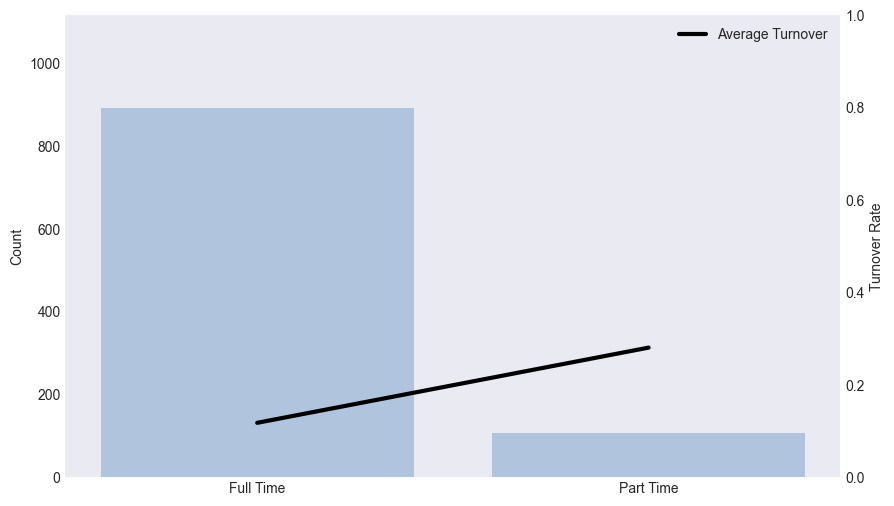

In [16]:
build_chart(df=employee_turnover, var='employment_status', target='turnover', rotation=0)

### Peer Recognition Awards

As the number of peer recognition awards an employee receives increases, the turnover rate generally decreases. \
This may indicate that **employees who receive more awards might be more likely to stay at the company**.

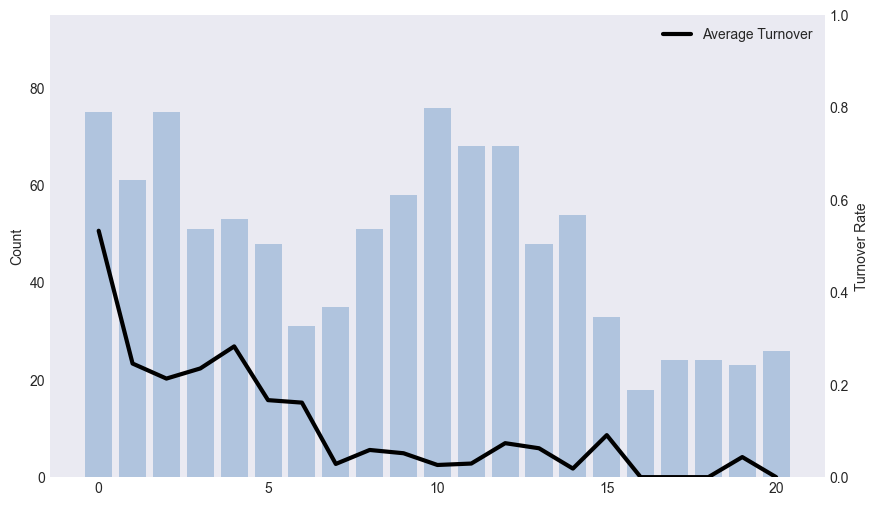

In [17]:
build_chart(df=employee_turnover, var='awards', target='turnover', rotation=0)

### Team-Level Survey Job Satisfaction

A significant number of employees are very happy (Green), as indicated by the highest count. \
The teams with the **happiest employees (Green) have the lowest turnover rate, while the unhappiest (Red) have a higher turnover rate**.

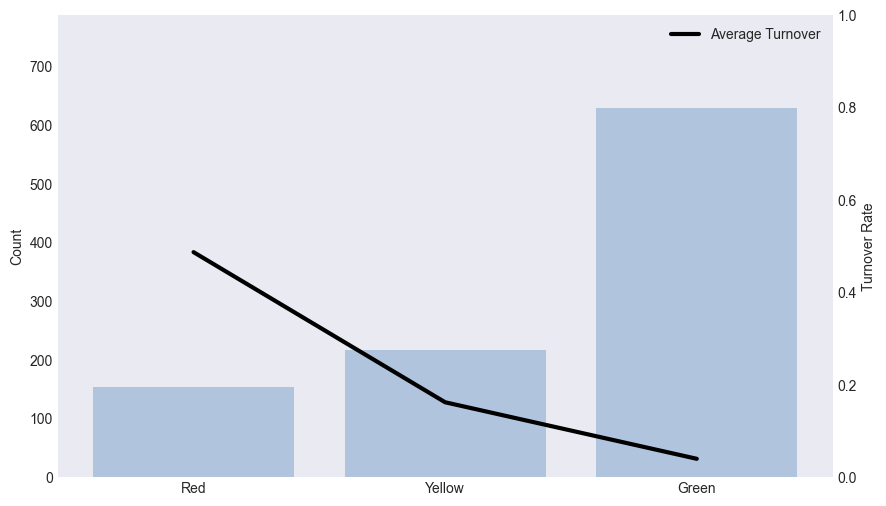

In [18]:
build_chart(df=employee_turnover, var='team_level_survey_satisfication', target='turnover', rotation=0, sort_order_list=['Red','Yellow','Green'])

# <a id='5'>5. Building Machine Learning Models</a>

## <a id='5.1'>5.1. Pre-Process Dataset</a>

In [19]:
# Pre-process dataset
employee_turnover = preprocess_dataset(employee_turnover)

# Make copy of target and remove target and redundant features
target = employee_turnover['turnover'].copy()
employee_turnover.drop(['turnover', 'employee_id'], axis=1, inplace=True)

# Split into train and test using stratify=y to maintain the same ratio while splitting
X_train, X_test, y_train, y_test = train_test_split(employee_turnover,target,test_size=0.25,random_state=42,stratify=target)

## <a id='5.2'>5.2. Baseline Models</a>

The **Random Forest**, **Gradient Boosting**, and **Extra Trees** models have the best baseline performance

In [20]:
# Initiate baseline classifier algorithms
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

# Create models and scores lists
models = [ran, knn, xgb, gbc, svc, ext, gnb, gpc, bag]         
scores = []

# Fit and cross validate all models
for mod in models:
    mod.fit(X_train, y_train)
    auc_score = cross_val_score(mod, X_train, y_train, scoring = "roc_auc", cv = 10)
    scores.append(auc_score.mean())

# Create a results table ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbor', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier'],
    'Baseline Score': scores})

result_df = results.sort_values(by='Baseline Score', ascending=False).reset_index(drop=True)
result_df

,Model,Baseline Score
0,Random Forest,0.894433
1,Gradient Boosting,0.888287
2,Extra Trees,0.880741
3,Bagging Classifier,0.871541
4,XGBoost,0.868635
5,SVC,0.866872
6,Gaussian Naive Bayes,0.854220
7,K Nearest Neighbor,0.829112
8,Gaussian Process,0.815734


## <a id='5.3'>5.3. Feature Selection Models</a>

After removing redundant features, the **Random Forest**, **Gradient Boosting**, and **XGBoost** models have the best performance

In [21]:
# Get feature importance for top 4 models and merge into DataFrame
ran_imp = pd.DataFrame({'Feature':employee_turnover.columns, 'ran importance':ran.feature_importances_})
gbc_imp = pd.DataFrame({'Feature':employee_turnover.columns, 'gbc importance':gbc.feature_importances_})
ext_imp = pd.DataFrame({'Feature':employee_turnover.columns, 'ext importance':ext.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':employee_turnover.columns, 'xgb importance':xgb.feature_importances_})
importance = reduce(lambda left, right: pd.merge(left, right, on='Feature', how='outer'), [ran_imp, gbc_imp, ext_imp, xgb_imp])

# Create a list of the most important features
top_features = list(set(importance['Feature']) - set(importance[(importance['ran importance']<0.025)&(importance['gbc importance']<0.025)&(importance['ext importance']<0.025)&(importance['xgb importance']<0.025)]['Feature']))

# Create models and scores lists
models = [ran, knn, xgb, gbc, svc, ext, gnb, gpc, bag]         
scores_v2 = []

# Drop redundant features and re-train
for mod in models:
    mod.fit(X_train[top_features], y_train)
    auc_score = cross_val_score(mod, X_train[top_features], y_train, scoring = "roc_auc", cv = 10)
    scores_v2.append(auc_score.mean())

# Create a results table ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbor', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier'],
    'Baseline Score': scores,
    'Feature Selection Score': scores_v2})

result_df = results.sort_values(by='Feature Selection Score', ascending=False).reset_index(drop=True)
result_df

,Model,Baseline Score,Feature Selection Score
0,Random Forest,0.894433,0.892606
1,Gradient Boosting,0.888287,0.891127
2,XGBoost,0.868635,0.880151
3,Extra Trees,0.880741,0.879150
4,SVC,0.866872,0.866528
5,Bagging Classifier,0.871541,0.864740
6,Gaussian Naive Bayes,0.854220,0.857522
7,K Nearest Neighbor,0.829112,0.843574
8,Gaussian Process,0.815734,0.834800


## <a id='5.4'>5.4. Grid Search</a>

#### SVC

In [22]:
# Search parameters
Cs = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100]
gammas = [0.001, 0.01, 0.1, 1]

# Create hyperparameter grid
hyperparams = {'C': Cs, 'gamma' : gammas}

# Run GridSearchCV
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
0.8724223812363346
SVC(C=1, gamma=0.01, probability=True)
{'C': 1, 'gamma': 0.01}


#### Gaussian Process

In [23]:
# Search parameters
n_restarts_optimizer = [0, 1, 2]
max_iter_predict = [1, 2, 5, 20]
warm_start = [True, False]

# Create hyperparameter grid
hyperparams = {'n_restarts_optimizer': n_restarts_optimizer, 'max_iter_predict': max_iter_predict, 'warm_start': warm_start}

# Run GridSearchCV
gd=GridSearchCV(estimator = GaussianProcessClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.8307257006559332
GaussianProcessClassifier(max_iter_predict=2, warm_start=True)
{'max_iter_predict': 2, 'n_restarts_optimizer': 0, 'warm_start': True}


#### K Nearest Neighbors

In [24]:
# Search parameters
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]

# Create hyperparameter grid
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

# Run GridSearchCV
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.8872457335945707
KNeighborsClassifier(leaf_size=1, n_neighbors=20, weights='distance')
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 20, 'weights': 'distance'}


#### Random Forest

In [25]:
# Search parameters
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [1, 3, 5, 7]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]

# Create hyperparameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearchCV
gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
0.9104055427776357
RandomForestClassifier(max_features=5, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50)
{'max_depth': None, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


#### Extra Trees

In [26]:
# Search parameters
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [1, 3, 5, 7]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]

# Create hyperparameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearchCV
gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
0.9135801459522389
ExtraTreesClassifier(max_features=3, min_samples_leaf=2, min_samples_split=4,
                     n_estimators=10)
{'max_depth': None, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10}


#### Bagging Classifier

In [27]:
# Search parameters
n_estimators = [10, 15, 20, 25, 50, 75, 100, 150]
max_samples = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 50]
max_features = [1, 3, 5, 7]

# Create hyperparameter grid
hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}

# Run GridSearchCV
gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 352 candidates, totalling 1760 fits
0.891513871141778
BaggingClassifier(max_features=7, max_samples=50, n_estimators=75)
{'max_features': 7, 'max_samples': 50, 'n_estimators': 75}


#### Gradient Boosting

In [28]:
# Search parameters
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [100, 250, 500, 750, 1000, 1250, 1500]

# Create hyperparameter grid
hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

# Run GridSearchCV
gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
0.9031035863361445
GradientBoostingClassifier(learning_rate=0.05, n_estimators=250)
{'learning_rate': 0.05, 'n_estimators': 250}


In [29]:
# Search parameters
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2]
max_features = [None, 'sqrt', 'log2']

# Create hyperparameter grid
hyperparams = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features}

# Run GridSearchCV
gd=GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=250), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
0.9066526535480024
GradientBoostingClassifier(learning_rate=0.05, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=4,
                           n_estimators=250)
{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4}


In [30]:
# Search parameters
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

# Create hyperparameter grid
hyperparams = {'subsample': subsample}

# Run GridSearchCV
gd=GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=250, max_depth=3, 
                                          min_samples_split=4, min_samples_leaf=2, max_features='sqrt'), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.9067530170088309
GradientBoostingClassifier(learning_rate=0.05, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=4,
                           n_estimators=250, subsample=0.75)
{'subsample': 0.75}


#### XGBoost

In [31]:
# Search parameters
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [10, 25, 50, 75, 100, 250, 500, 750, 1000]

# Create hyperparameter grid
hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

# Run GridSearchCV
gd=GridSearchCV(estimator = XGBClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.9008785529715763
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
{'learning_rate': 0.01, 'n_estimators': 750}


In [32]:
# Search parameters
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]

# Create hyperparameter grid
hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

# Run GridSearchCV
gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.01, n_estimators=750), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.9014386801828662
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
{'max_depth': 6, 'min_child_weight': 2}


In [33]:
# Search parameters
gamma = [i*0.1 for i in range(0,5)]

# Create hyperparameter grid
hyperparams = {'gamma': gamma}

# Run GridSearchCV
gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.01, n_estimators=750, max_depth=6, 
                                          min_child_weight=2), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9014386801828662
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
{'gamma': 0.0}


In [34]:
# Search parameters
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    
# Create hyperparameter grid
hyperparams = {'subsample': subsample, 'colsample_bytree': colsample_bytree}

# Run GridSearchCV
gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.01, n_estimators=750, max_depth=6, 
                                          min_child_weight=2, gamma=0.0), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.9014386801828662
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=750,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
{'colsample_bytree': 1, 'subsample': 1}


In [35]:
# Search parameters
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]

# Create hyperparameter grid
hyperparams = {'reg_alpha': reg_alpha}

# Run GridSearchCV
gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.01, n_estimators=750, max_depth=6, 
                                          min_child_weight=2, gamma=0.0, subsample=1, colsample_bytree=1),
                                         param_grid = hyperparams, verbose=True, cv=5, scoring = "roc_auc")

# Fit model and return best score, estimator, and parameters
gd.fit(X_train[top_features], y_train)
print(gd.best_score_)
print(gd.best_estimator_)
print(gd.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9009957122980378
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=750,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
{'reg_alpha': 1e-05}


## <a id='5.5'>5.5. Tuned Models</a>

After removing redundant features and performing a grid search for each algorithm, the **Random Forest** model has the best performance

In [36]:
# Initiate tuned classifier algorithms
ran = RandomForestClassifier(n_estimators=50,
                             max_depth=None, 
                             max_features=5,
                             min_samples_leaf=2, 
                             min_samples_split=10,  
                             random_state=1)

knn = KNeighborsClassifier(algorithm='auto', 
                           leaf_size=1, 
                           n_neighbors=20, 
                           weights='distance')

xgb = XGBClassifier(learning_rate=0.01, 
                    n_estimators=750,
                    max_depth=6,
                    min_child_weight=2,
                    gamma=0.0,
                    colsample_bytree=1,
                    subsample=1,
                    reg_alpha=1e-5,
                    random_state=1)

gbc = GradientBoostingClassifier(learning_rate=0.05,
                                 n_estimators=250,
                                 max_features='sqrt',
                                 min_samples_split=4,
                                 min_samples_leaf=2,
                                 subsample=0.75,
                                 random_state=1)

svc = SVC(C=1,gamma=0.01,probability=True)

ext = ExtraTreesClassifier(max_depth=None, 
                           max_features=3,
                           min_samples_leaf=2,
                           min_samples_split=4,
                           n_estimators=10,
                           random_state=1)


gpc = GaussianProcessClassifier(max_iter_predict=2, warm_start=True, n_restarts_optimizer=0)

bag = BaggingClassifier(max_features=7,max_samples=50,n_estimators=75,random_state=1)

# Create models and scores lists
models = [ran, knn, xgb, gbc, svc, ext, gnb, gpc, bag]   
scores_v3 = []

# Fit and cross validate all models
for mod in models:
    mod.fit(X_train[top_features], y_train)
    auc_score = cross_val_score(mod, X_train[top_features], y_train, scoring = "roc_auc", cv = 10)
    scores_v3.append(auc_score.mean())

# Create a results table ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbor', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier'],
    'Baseline Score': scores,
    'Feature Selection Score': scores_v2,
    'Tuned Score': scores_v3})

result_df = results.sort_values(by='Tuned Score', ascending=False).reset_index(drop=True)
result_df

,Model,Baseline Score,Feature Selection Score,Tuned Score
0,Random Forest,0.894433,0.892606,0.903399
1,Extra Trees,0.880741,0.879150,0.902382
2,Gradient Boosting,0.888287,0.891127,0.899796
3,K Nearest Neighbor,0.829112,0.843574,0.890264
4,XGBoost,0.868635,0.880151,0.886707
5,Bagging Classifier,0.871541,0.864740,0.877097
6,SVC,0.866872,0.866528,0.867889
7,Gaussian Naive Bayes,0.854220,0.857522,0.857522
8,Gaussian Process,0.815734,0.834800,0.834800


## <a id='5.6'>5.6. Final Model Prediction and Explanation</a>

The **Random Forest** model also demonstrates strong performance on the test set, achieving an **AUC score of 0.88**

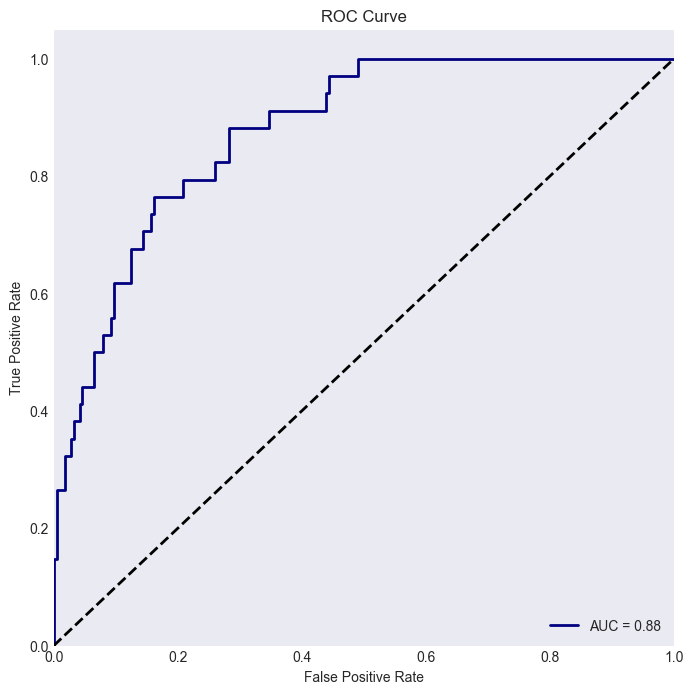

In [37]:
# Calculate fpr, tpr, and auc score
y_pred_proba = ran.predict_proba(X_test[top_features])[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='navy', lw=2, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0,1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The most important features for the Random Forest model are **Team-Level Survey Job Satisfaction**, **Number of Surveys Taken**, and **Salary Relative To Peers**

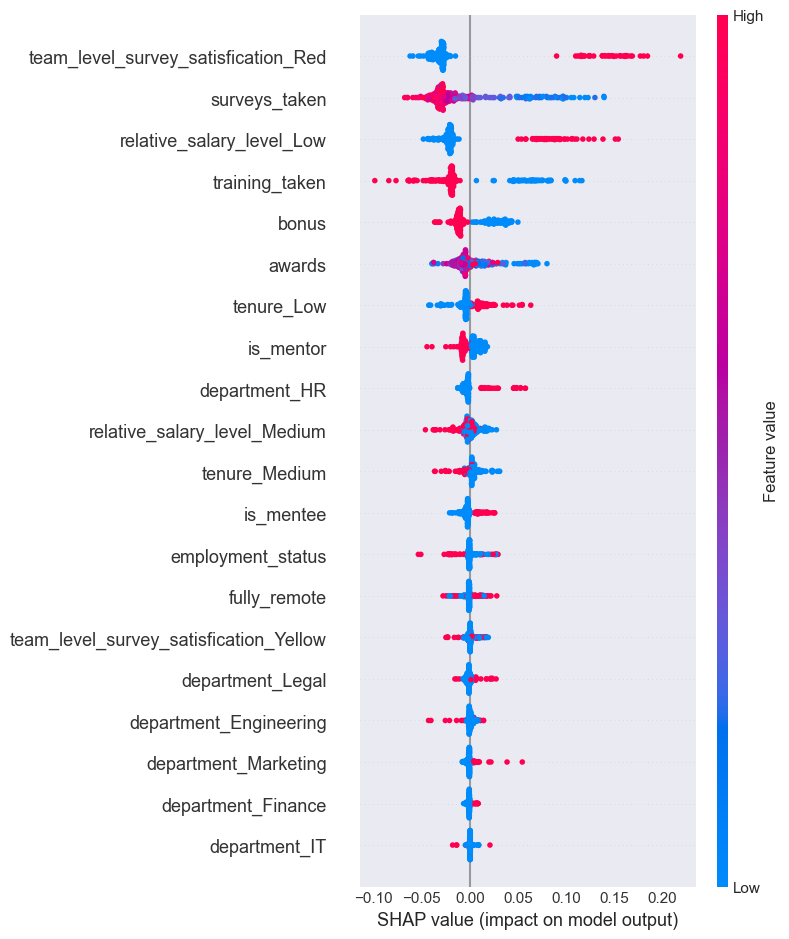

In [40]:
# Calculate Shapley values
explainer = shap.TreeExplainer(ran)
shap_values = explainer.shap_values(X_test[top_features])

# Summary plot for Shapley values
shap.summary_plot(shap_values[1], X_test[top_features])
plt.show()

# <a id='6'>6. Concluding Remarks</a>

## <a id='6.1'>6.1. Main Takeaways</a>

> **135** employees left the company giving an overall turnover rate of **13.5%**

> The company is doing a **good job of retaining long-term employees but struggling with newer employees**. There may be an opportunity to enhance the onboarding process and offer clear paths for career growth and development.

> **Employees that are more engaged tend to have a much lower turnover rate**, as indicated by participation in mentor/mentee program, completing training, taking company surveys, and working in the office. The company should consider adding more opportunities like team building activities, leadership development, and networking events to boost engagement and decrease turnover.

> **High-performing, high-earning employees tend to have a much lower turnover rate**, as indicated by salary relative to peers, receiving a bonus, and number of peer recoginition awards. The company should consider encouraging regular performance feedback and training opportunities for employees that are not in the high-performing, high-earning category. **The company should also consider using team-level job satisfaction surveys as an indicator for teams at risk for turnover**.

## <a id='6.2'>6.2. Potential Next Steps</a>

> As the company collects more data on its employees, **the model can be enhanced using the additional data**. The company could also explore collecting new data like years in current role, years with current manager, and years since last promotion.

> The predictive model above can be used to assign each employee a "risk score" based on the predicted turnover such that **each employee will be categorized as Low-Risk, Medium-Risk, and High-Risk**.

> The HR team can use these findings to **implement new programs and opportunities to help lower overall turnover rate** as well as place more emphasis on employees categorized as "High-Risk".